In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MultiLabelBinarizer, PolynomialFeatures
from sklearn.metrics import mean_squared_error, max_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler

from typing import Sequence

In [2]:
def reshape(df: pd.DataFrame, scale:bool =False, start=1960, stop=2016) -> pd.DataFrame:
    columns = df["Country Name"]
    index = range(start, stop+1)
    data = df[[f"{i}" for i in index]].to_numpy().T
    
    df = pd.DataFrame(data = data,
                        columns=columns,
                        index=index)
    if scale:
        df = ( df-df.mean() ) / df.std() 
    return df
    

In [3]:
filter_ = lambda df, country: df[df["Country Name"].isin(country)]

In [4]:
pop = pd.read_csv("data/country_population.csv")
pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0


In [5]:
fert_rate = pd.read_csv("data/fertility_rate.csv")
fert_rate.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,4.820,4.655,4.471,4.271,4.059,3.842,...,1.763,1.764,1.769,1.776,1.783,1.791,1.796,1.800,1.801,1.800
1,Afghanistan,AFG,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.450,7.450,7.450,7.450,7.450,7.450,...,6.460,6.254,6.038,5.816,5.595,5.380,5.174,4.981,4.802,4.635
2,Angola,AGO,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.478,7.524,7.563,7.592,7.611,7.619,...,6.368,6.307,6.238,6.162,6.082,6.000,5.920,5.841,5.766,5.694
3,Albania,ALB,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,6.489,6.401,6.282,6.133,5.960,5.773,...,1.668,1.650,1.646,1.653,1.668,1.685,1.700,1.710,1.714,1.713
4,Andorra,AND,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.180,1.250,1.190,1.270,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
life_expect = pd.read_csv("data/life_expectancy.csv")
life_expect.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,65.662,66.074,66.444,66.787,67.113,67.435,...,74.576,74.725,74.872,75.016,75.158,75.299,75.440,75.582,75.725,75.867
1,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,32.292,32.742,33.185,33.624,34.060,34.495,...,59.694,60.243,60.754,61.226,61.666,62.086,62.494,62.895,63.288,63.673
2,Angola,AGO,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,33.251,33.573,33.914,34.272,34.645,35.031,...,55.096,56.189,57.231,58.192,59.042,59.770,60.373,60.858,61.241,61.547
3,Albania,ALB,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,62.279,63.298,64.187,64.911,65.461,65.848,...,75.656,75.943,76.281,76.652,77.031,77.389,77.702,77.963,78.174,78.345
4,Andorra,AND,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
countries = list(pop["Country Name"].sample(n=10, random_state=66))
pprint(list(enumerate(countries)))

[(0, 'Solomon Islands'),
 (1, 'Finland'),
 (2, 'Burkina Faso'),
 (3, 'Switzerland'),
 (4, 'Timor-Leste'),
 (5, 'Portugal'),
 (6, 'Chile'),
 (7, 'Bosnia and Herzegovina'),
 (8, 'Uruguay'),
 (9, 'Russian Federation')]


In [15]:
label = countries[5]
#pop, life_expect, fert_rate
data = pop

<AxesSubplot: xlabel='Year', ylabel='___'>

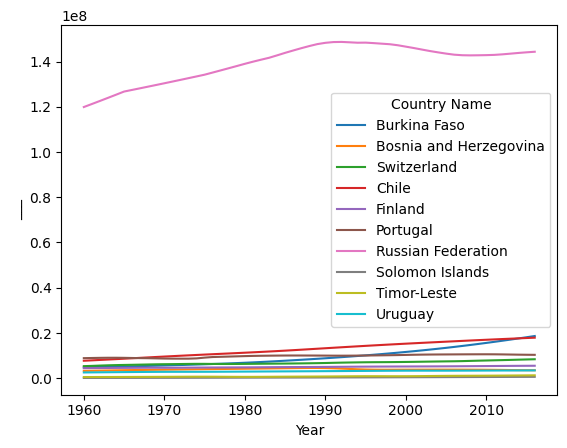

In [17]:
reshape(filter_(data, countries)).plot(xlabel="Year", ylabel="___")

In [18]:
reshape(data)[label].iloc[:5]

1960    8857716.0
1961    8929316.0
1962    8993985.0
1963    9030355.0
1964    9035365.0
Name: Portugal, dtype: float64

In [19]:
def to_matrix(X: pd.Series, lags=5):
        new_X = pd.DataFrame( 
            data={ -i: X.shift(i) for i in range(1, lags + 1) }
        ).dropna()
        y = X.loc[new_X.index]
        return pd.concat((new_X, y), axis=1)

In [20]:
to_matrix(reshape(data)[label], lags=10).corr()[label]

-1          0.992595
-2          0.973116
-3          0.946667
-4          0.914977
-5          0.878788
-6          0.840709
-7          0.803903
-8          0.770807
-9          0.744352
-10         0.726529
Portugal    1.000000
Name: Portugal, dtype: float64

In [21]:
class ForecastModel:
    def __init__(self, 
                 estimator = LinearRegression(), 
                 lag : int = 5):
        self._estimator = estimator
        self.lag = lag
    
    def fit(self, X: Sequence, min_train=None, max_train=None):
        self.X, self.y, self.raw = self.to_matrix(X)
        self.max_year = self.X.index.max()
        self.min_year = self.X.index.min()
        if min_train == None: min_train = self.min_year
        if max_train == None: max_train = self.max_year
        self._estimator.fit(self.X.loc[min_train:max_train], self.y.loc[min_train:max_train])
        return self
    
    def predict(self, years: Sequence) -> Sequence:
        X = []
        for year in years:
            assert(year>=self.min_year)
            X += [self.get_lags(year)]

        return self._estimator.predict( X )
    
    def get_lags(self, year: int) -> Sequence:
        return [self.get_year(year - i) for i in range(1,self.lag+1)]
    
    def get_year(self, year: int) -> float:
        try: 
            return self.raw.loc[year]
        except:
            #print(f"Predicting non-existing: {year}")
            pred = self.predict([year])[0]
            self.raw.loc[year] = pred
            return self.raw.loc[year]
        
    def to_matrix(self, X: pd.Series):
        new_X = pd.DataFrame( 
            data={ -i: X.shift(i) for i in range(1, self.lag + 1) }
        ).dropna()
        y = X.loc[new_X.index]
        
        return new_X, y, X

In [51]:
model = ForecastModel(lag=5).fit(reshape(data)[label])

In [52]:
train_pred = model.predict([2016])
real = model.raw.loc[2016]
err = mean_squared_error([real], train_pred, squared=False)
print(f"""Predicted value is: {train_pred[0]:.3f};
True value is: {real:.3f};

Root Mean Squared Error is: {err:.3f}
Error in relation to mean is: {err/model.raw.mean():.3f}""")

Predicted value is: 10328204.269;
True value is: 10325452.000;

Root Mean Squared Error is: 2752.269
Error in relation to mean is: 0.000


In [53]:
min_year = 2005;
max_year = 2016;

In [54]:
preds = model.predict( list(range(min_year, 2017)))

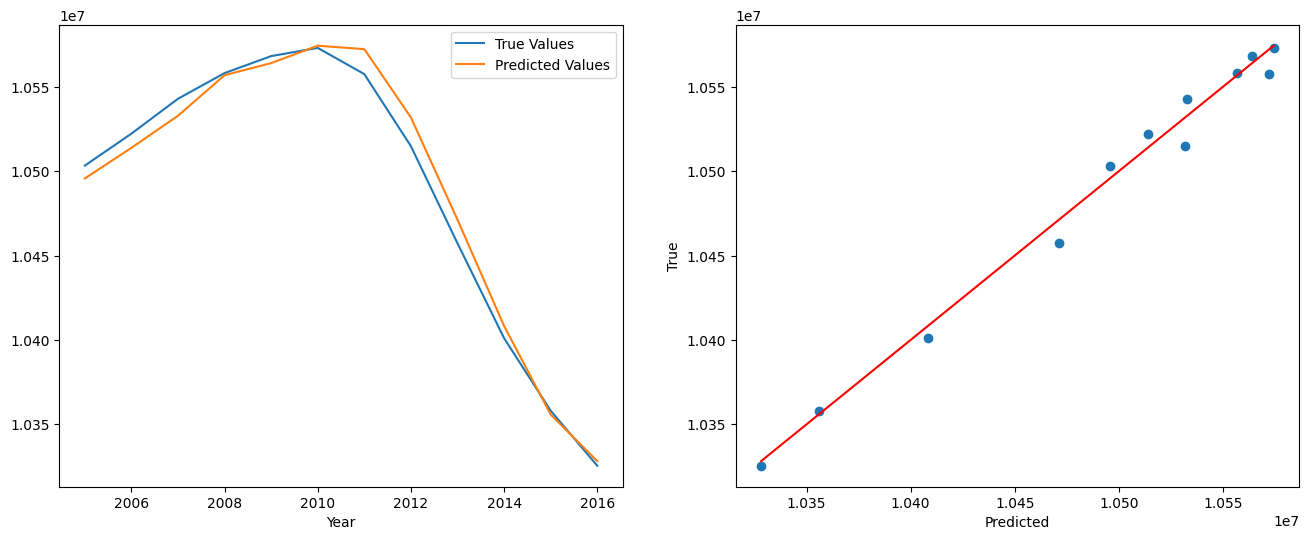

In [55]:
def plot_sub(ax, x, y, label="", xlabel="", ylabel="", title=""):
    ax.plot(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()

def scat_sub(ax, x, y, label="", xlabel="", ylabel="", title=""):
    ax.scatter(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()
    
f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], range(min_year,max_year+1), reshape(data)[label].loc[min_year:max_year], label="True Values")
plot_sub(ax[0], range(min_year,max_year+1), preds, label="Predicted Values", xlabel="Year")

scat_sub(ax[1], preds, reshape(data)[label].loc[min_year:max_year], xlabel="Predicted", ylabel="True")
xy=np.linspace(preds.min(), preds.max())
ax[1].plot(xy,xy, "r")

In [56]:
#real data from 2017 to 2021 in portugal
y_test = pd.read_csv("data/country_population_test.csv", index_col=0)[label]

In [57]:
preds = model.predict(range(2017,2022))

In [58]:
preds

array([10302544.92987746, 10292601.34237327, 10293995.39590739,
       10301329.09521397, 10311645.68613347])

In [59]:
mean_squared_error( y_test, preds, squared=False)

7865.7088478382375

Text(0.5, 1.0, 'Portugal')

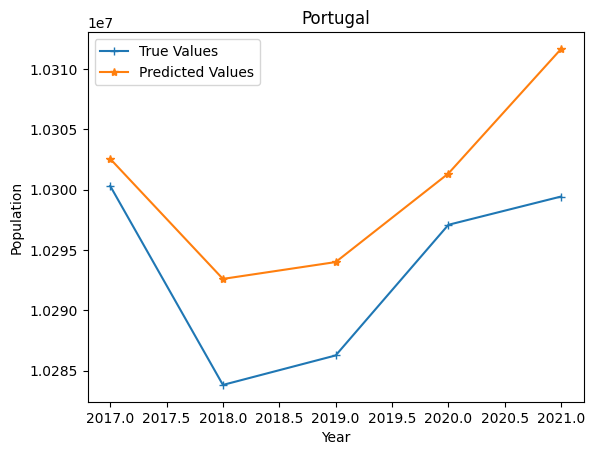

In [60]:
plt.plot(range(2017, 2022), y_test, "-+", label="True Values")
plt.plot(range(2017, 2022), preds, "-*", label ="Predicted Values")
#plt.plot(mean_squared_error( reshape(pop)["Portugal"].loc[1965: 2015], preds, squared=False), color="green")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Population")
plt.title(label)